In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn import neighbors, linear_model, svm, tree, ensemble
from sklearn.decomposition import PCA

warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

%matplotlib inline

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Data Cleaning

In [ ]:
data = pd.read_excel('online_retail_II.xlsx', sheet_name = [0])[0]
data = data.dropna(subset=['Invoice', 'StockCode', 'Quantity', 'InvoiceDate', 'Price', 'Customer ID', 'Country'], how='any')
'''
drop the nan on all of the rows except for 'Description' since we don't care about whether it is missing or not.

*   before:525461
*   new: 417534

107927 rows are dropped
'''

data.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
data_purchase, data_cancel = data[data['Quantity']>0], data[data['Quantity']<0]
assert data_purchase.shape[0]+data_cancel.shape[0] == data.shape[0]
print(f'purchase rows:{data_purchase.shape[0]}, refund rows:{data_cancel.shape[0]}')

def adjust_type(df):
    df = df.astype({'StockCode': 'str', 'Customer ID':'int'})
    df = df.astype({'Customer ID':'str'})
    return df

data_cancel = adjust_type(data_cancel)
data_purchase = adjust_type(data_purchase)
data = adjust_type(data)

data_cancel.head()

purchase rows:407695, refund rows:9839


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
178,C489449,22087,PAPER BUNTING WHITE LACE,-12,2009-12-01 10:33:00,2.95,16321,Australia
179,C489449,85206A,CREAM FELT EASTER EGG BASKET,-6,2009-12-01 10:33:00,1.65,16321,Australia
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia
181,C489449,21896,POTTING SHED TWINE,-6,2009-12-01 10:33:00,2.10,16321,Australia
182,C489449,22083,PAPER CHAIN KIT RETRO SPOT,-12,2009-12-01 10:33:00,2.95,16321,Australia


In [ ]:
def get_closest_left(given_list, target):
    res = -1
    for n in given_list:
        if n <= target:
            res = n
        else:
            break
    return res

def get_closest_right(given_list, target):
    res = -1
    for n in given_list:
        if n > target:
            res = n
            break
    return res

unable_to_process = []

for index, row in data_cancel.iterrows():
    try:
        data_purchases_candidates = list(data_purchase[(data_purchase['StockCode'] == row['StockCode']) & (data_purchase['Customer ID'] == row['Customer ID'])].index)
        clostest_idx_left = get_closest_left(data_purchases_candidates, index)
        if clostest_idx_left == -1: unable_to_process.append(index)

        elif data_purchase.at[clostest_idx_left, 'Price'] == row['Price'] and data_purchase.at[clostest_idx_left, 'Quantity'] >= -row['Quantity']:
            data_purchase.at[clostest_idx_left, 'Quantity'] += row['Quantity']
            if data_purchase.at[clostest_idx_left, 'Quantity'] == 0:
                data_purchase = data_purchase.drop(index=[clostest_idx_left])
    except Exception as e:
        unable_to_process.append(index)

In [ ]:
print(f'{len(data_cancel) - len(unable_to_process)} cancelled orders has been processed')
print(len(data_purchase))

8107 cancelled orders has been processed
404845


In [ ]:
data_cancel = data_cancel.loc[unable_to_process]
unable_to_process = []
for index, row in data_cancel.iterrows():
    try:
        data_purchases_candidates = list(data_purchase[(data_purchase['StockCode'] == row['StockCode']) & (data_purchase['Customer ID'] == row['Customer ID'])].index)
        clostest_idx_right = get_closest_right(data_purchases_candidates, index)

        if clostest_idx_right == -1: unable_to_process.append(index)

        elif data_purchase.at[clostest_idx_right, 'Price'] == row['Price'] and data_purchase.at[clostest_idx_right, 'Quantity'] == -row['Quantity'] and data_purchase.at[clostest_idx_right, 'Country'] == row['Country']:
            data_purchase = data_purchase.drop(index=[clostest_idx_right])

    except Exception as e:
        unable_to_process.append(index)

In [ ]:
print(f'{len(data_cancel) - len(unable_to_process)} cancelled orders has been processed')
print(len(data_purchase))

459 cancelled orders has been processed
404669


In [ ]:
data_purchase.to_csv('./cleaned_online_retail.csv')

In [ ]:
data_cancel.loc[unable_to_process]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
285,C489476,22149,FELTCRAFT 6 FLOWER FRIENDS,-6,2009-12-01 10:55:00,2.10,13293,United Kingdom
318,C489504,85083,KISS REINDEER SCANDINAVIAN STOCKING,-6,2009-12-01 11:10:00,2.55,13916,United Kingdom
399,C489518,20892,SET/3 TALL GLASS CANDLE HOLDER PINK,-2,2009-12-01 11:35:00,12.75,15461,United Kingdom
400,C489518,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,-1,2009-12-01 11:35:00,7.95,15461,United Kingdom
401,C489518,22138,BAKING SET 9 PIECE RETROSPOT,-1,2009-12-01 11:35:00,4.95,15461,United Kingdom
...,...,...,...,...,...,...,...,...
517464,C537602,22065,CHRISTMAS PUDDING TRINKET POT,-1,2010-12-07 12:45:00,1.25,17511,United Kingdom
522330,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340,United Kingdom
524403,C538081,22630,DOLLY GIRL LUNCH BOX,-33,2010-12-09 14:29:00,1.95,16898,United Kingdom
524635,C538109,22780,LIGHT GARLAND BUTTERFILES PINK,-4,2010-12-09 15:23:00,4.25,16042,United Kingdom


In [ ]:
tid = 180
t1, t2 = list(data_cancel.loc[[tid]]['StockCode'])[0], list(data_cancel.loc[[tid]]['Customer ID'])[0]
data_cancel.loc[[tid]]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia


In [ ]:
data[(data['StockCode'] == t1) & (data['Customer ID'] == t2)]

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
180,C489449,21895,POTTING SHED SOW 'N' GROW SET,-4,2009-12-01 10:33:00,4.25,16321,Australia
189,489450,21895,POTTING SHED SOW 'N' GROW SET,4,2009-12-01 10:36:00,4.25,16321,Australia


In [ ]:
df = pd.read_csv('./cleaned_online_retail.csv', index_col=0).drop_duplicates()

# Feature Exploring/Engineering

Country - the main customers are from UK

In [ ]:
country_invoice_customer = (df[['Invoice', 'Customer ID', 'Country']].groupby(['Invoice', 'Customer ID', 'Country']).count().reset_index(drop = False)['Country'].value_counts())
print(f'{len(country_invoice_customer)} unique countries')
pd.DataFrame(country_invoice_customer).head()

37 unique countries


,Country
United Kingdom,17453
Germany,344
EIRE,307
France,234
Netherlands,133


Description - find the most-occured nouns

In [ ]:
from collections import defaultdict
stemmer = nltk.stem.SnowballStemmer("english")
kw_roots, kw_cnt = defaultdict(set), defaultdict(int)

for desc in df['Description'].unique():
    for w in [w for w, tag in nltk.pos_tag(nltk.word_tokenize(desc.lower())) if tag.startswith('NN')]:
        root = stemmer.stem(w)
        kw_roots[root].add(w)
        kw_cnt[root]+=1

kw_validated, kw_noun = dict(), []
for root in kw_roots.keys():
    if len(kw_roots[root]) > 1:
        best_fit = min((word for word in kw_roots[root] if word), key=len)
        kw_validated[root] = best_fit
        kw_noun.append(best_fit)
    else:
        kw_validated[root] = list(kw_roots[root])[0]
        kw_noun.append(list(kw_roots[root])[0])

from matplotlib.colors import is_color_like

filtered_desc_word_ocurrence = []
for w, cnt in sorted([[kw_validated[k],v] for k,v in kw_cnt.items()], key = lambda x:x[1], reverse = True):
    if is_color_like(w): continue
    elif not w.isalpha(): continue
    filtered_desc_word_ocurrence.append([w, cnt])
filtered_desc_word_ocurrence = filtered_desc_word_ocurrence[:len(filtered_desc_word_ocurrence)//5]
pd.DataFrame(filtered_desc_word_ocurrence).rename(columns={0:'word', 1:'count'})

,word,count
0,heart,232
1,candle,212
2,set,194
3,glass,191
4,vintage,178
...,...,...
276,boudicca,10
277,charlie,9
278,empire,9
279,measure,9


Cluster these product keywords into different groups

In [ ]:
X = pd.DataFrame()
for key, occurence in filtered_desc_word_ocurrence:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in x), df['Description'].unique()))

In [ ]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(df['Description'].unique()):
    prix = df[ df['Description'] == prod]['Price'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

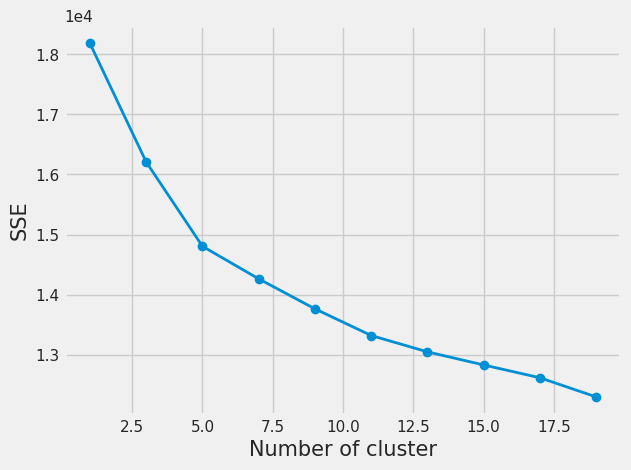

In [ ]:
from sklearn.preprocessing import StandardScaler

def kmeans_and_plot(input):
    SSE = {}
    for k in range(1, 20, 2):
        kmeans = KMeans(n_clusters=k, init='k-means++', random_state=10, max_iter=1000).fit(input)
        SSE[k] = kmeans.inertia_

    plt.figure()
    plt.plot(list(SSE.keys()), list(SSE.values()), linewidth=2.0, marker = 'o')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.xlabel("Number of cluster", fontsize = 15)
    plt.ylabel("SSE", fontsize = 15)
    plt.grid(True)

    plt.show()

kmeans_and_plot(X.to_numpy())

In [ ]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=10, max_iter=1000).fit(X)
clusters = kmeans.predict(X)

pd.Series(clusters).value_counts()

1    1162
2     928
0     845
4     794
3     704
dtype: int64

In [ ]:
desc_group = dict()
for key, val in zip (df['Description'].unique(), clusters):
    desc_group[key] = val
df['stock_category'] = df.loc[:, 'Description'].map(desc_group)

for i in range(n_clusters):
    col_name = f'product_group_{i}_price'
    temp = df[df['stock_category'] == i]
    df.loc[:, col_name] = (temp['Price'] * (temp['Quantity'])).apply(lambda x:x if x > 0 else 0)
    df[col_name].fillna(0, inplace = True)

df.head(1)

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,stock_category,product_group_0_price,product_group_1_price,product_group_2_price,product_group_3_price,product_group_4_price
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085,United Kingdom,4,0.0,0.0,0.0,0.0,83.4


In [ ]:
target_col = ['product_group_0_price','product_group_1_price','product_group_2_price','product_group_3_price','product_group_4_price']
group_price = df.groupby(by=['Customer ID', 'Invoice']).sum()[target_col]
def combine_columns(row):
    target_col = ['product_group_0_price','product_group_1_price','product_group_2_price','product_group_3_price','product_group_4_price']
    total = 0
    for col in target_col:
        total+=row[col]
    return total

# Apply the custom function to create a new column 'Combined'
group_price['total_price'] = group_price.apply(combine_columns, axis=1)
group_price


product_group_0_price  product_group_1_price  \
Customer ID Invoice                                                 
12346       491725                    0.00                   0.00   
            491742                    0.00                   0.00   
            491744                    0.00                   0.00   
            492718                    0.00                   0.00   
            492722                    0.00                   0.00   
...                                    ...                    ...   
18286       519785                  203.10                 270.40   
18287       508581                  205.32                 501.32   
            523289                  595.62                 129.60   
            523290                   30.60                   0.00   
            534346                   50.40                 208.80   

                     product_group_2_price  product_group_3_price  \
Customer ID Invoice                                                 
12346       491725                    0.00                   45.0   
            491742                    0.00                   22.5   
            491744                    0.00                   22.5   
            492718                    0.00                   22.5   
            492722                    0.00                    1.0   
...                                    ...                    ...   
18286       519785                  148.54                   52.6   
18287       508581                  143.62                  192.7   
            523289                   41.58                   59.4   
            523290                    0.00                    0.0   
            534346                    0.00                   72.3   

                     product_group_4_price  total_price  
Customer ID Invoice                                      
12346       491725                    0.00        45.00  
            491742                    0.00        22.50  
            491744                    0.00        22.50  
            492718                    0.00        22.50  
            492722                    0.00         1.00  
...                                    ...          ...  
18286       519785                  158.84       833.48  
18287       508581                   28.65      1071.61  
            523289                   35.80       862.00  
            523290                    0.00        30.60  
            534346                   50.00       381.50  

[19011 rows x 6 columns]

In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['avg_invoice_date'] = df['InvoiceDate'].astype('int64')

avg_invoice_date = pd.DataFrame(df.groupby(['Customer ID', 'Invoice'])['avg_invoice_date'].mean())
avg_invoice_date['avg_invoice_date'] = pd.to_datetime(avg_invoice_date['avg_invoice_date'])

final = pd.concat([avg_invoice_date, group_price],axis=1).reset_index()
final.tail()


,Customer ID,Invoice,avg_invoice_date,product_group_0_price,product_group_1_price,product_group_2_price,product_group_3_price,product_group_4_price,total_price
19006,18286,519785,2010-08-20 11:57:00,203.10,270.40,148.54,52.6,158.84,833.48
19007,18287,508581,2010-05-17 11:55:00,205.32,501.32,143.62,192.7,28.65,1071.61
19008,18287,523289,2010-09-21 12:17:00,595.62,129.60,41.58,59.4,35.80,862.00
19009,18287,523290,2010-09-21 12:19:00,30.60,0.00,0.00,0.0,0.00,30.60
19010,18287,534346,2010-11-22 11:51:00,50.40,208.80,0.00,72.3,50.00,381.50


In [ ]:
def binify(m):
    if m in [12,1,2]: return 'Winter'
    elif m in [3,4,5]: return 'Spring'
    elif m in [6,7,8]: return 'Summer'
    else: return 'Fall'
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['bin_season'] = df['InvoiceDate'].dt.month.apply(binify)
df = pd.concat([df, pd.get_dummies(df['InvoiceDate'].dt.month.apply(binify))], axis=1)

season_df = df.groupby(['Customer ID']).sum()[['Fall','Spring', 'Summer', 'Winter']]
total_amount_df = pd.DataFrame(df.groupby(['Customer ID'])['Quantity'].sum())

customer_df = final.groupby(by=['Customer ID'])['total_price'].agg(['count','min','max','mean','sum'])
for i in range(n_clusters):
    col = f'product_group_{i}_price'
    customer_df.loc[:,col] = final.groupby(by=['Customer ID'])[col].sum()
customer_df['total_price'] = customer_df.apply(combine_columns, axis=1)


mix_df = pd.concat([customer_df, total_amount_df, season_df], axis = 1)

mix_df.head(2)

,count,min,max,mean,sum,product_group_0_price,product_group_1_price,product_group_2_price,product_group_3_price,product_group_4_price,total_price,Quantity,Fall,Spring,Summer,Winter
Customer ID,,,,,,,,,,,,,,,,
12346,11,1.00,142.31,33.487273,368.36,0.0,0.0,0.00,202.25,166.11,368.36,69,0,5,19,9
12347,2,611.53,711.79,661.660000,1323.32,312.9,353.4,200.98,276.35,179.69,1323.32,828,40,0,0,31


Use the feature-engineered table to group the customers

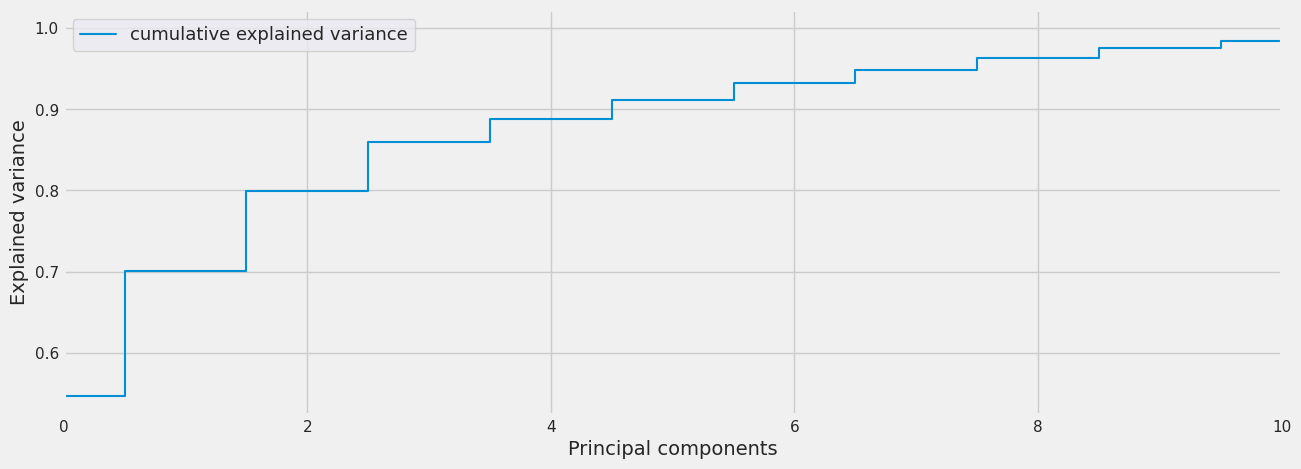

In [ ]:
from sklearn.preprocessing import StandardScaler

def pca_coverage(input):
    pca = PCA()
    pca.fit(input)
    pca_samples = pca.transform(input)

    fig, ax = plt.subplots(figsize=(14, 5))
    sns.set(font_scale=1)
    plt.step(range(input.shape[1]), pca.explained_variance_ratio_.cumsum(), where='mid',
            label='cumulative explained variance')
    plt.xlim(0, 10)

    ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

    plt.ylabel('Explained variance', fontsize = 14)
    plt.xlabel('Principal components', fontsize = 14)
    plt.legend(loc='best', fontsize = 13)

# sandardized_customer_df = StandardScaler().fit_transform(customer_df.to_numpy())
sandardized_mixed_df = StandardScaler().fit_transform(mix_df.to_numpy())
pca_coverage(sandardized_mixed_df)

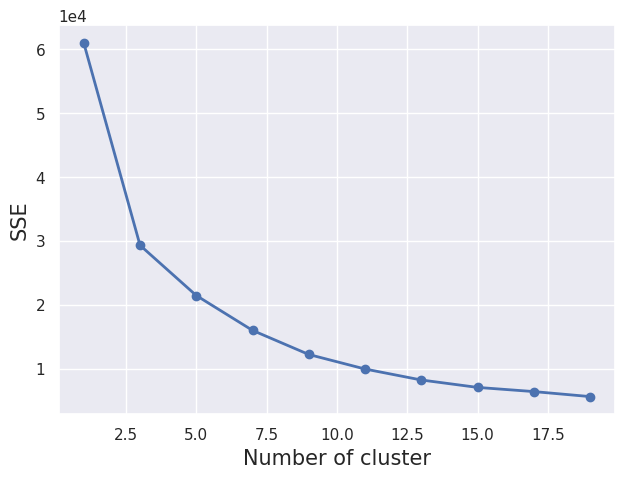

In [ ]:
pca = PCA(n_components=5)
pc_components = pca.fit_transform(sandardized_mixed_df)
kmeans_and_plot(pc_components)

In [ ]:
n_clusters = 5
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=10, max_iter=1000).fit(pc_components)
clusters = kmeans.predict(pc_components)

embeddings = pd.DataFrame(pc_components)
embeddings['clusters'] = clusters
embeddings

,0,1,2,3,4,clusters
0,-0.595211,0.639482,-0.806864,0.011887,-0.208847,1
1,-0.203990,-0.847526,0.916140,0.215291,-0.089346,1
2,-0.921637,-0.237294,-0.314820,-0.120203,0.090614,1
3,0.325149,-0.646271,0.543369,0.212201,0.254815,1
4,-0.871011,-0.391358,-0.103486,-0.013848,0.091705,1
...,...,...,...,...,...,...
4282,-0.012022,1.455329,-0.017191,0.044374,-0.157102,1
4283,-0.704421,-0.701448,0.370062,0.026486,0.121222,1
4284,-0.813279,-0.669617,0.204543,0.154621,-0.230737,1
4285,-0.229346,-0.537435,0.610311,0.184159,0.082781,1


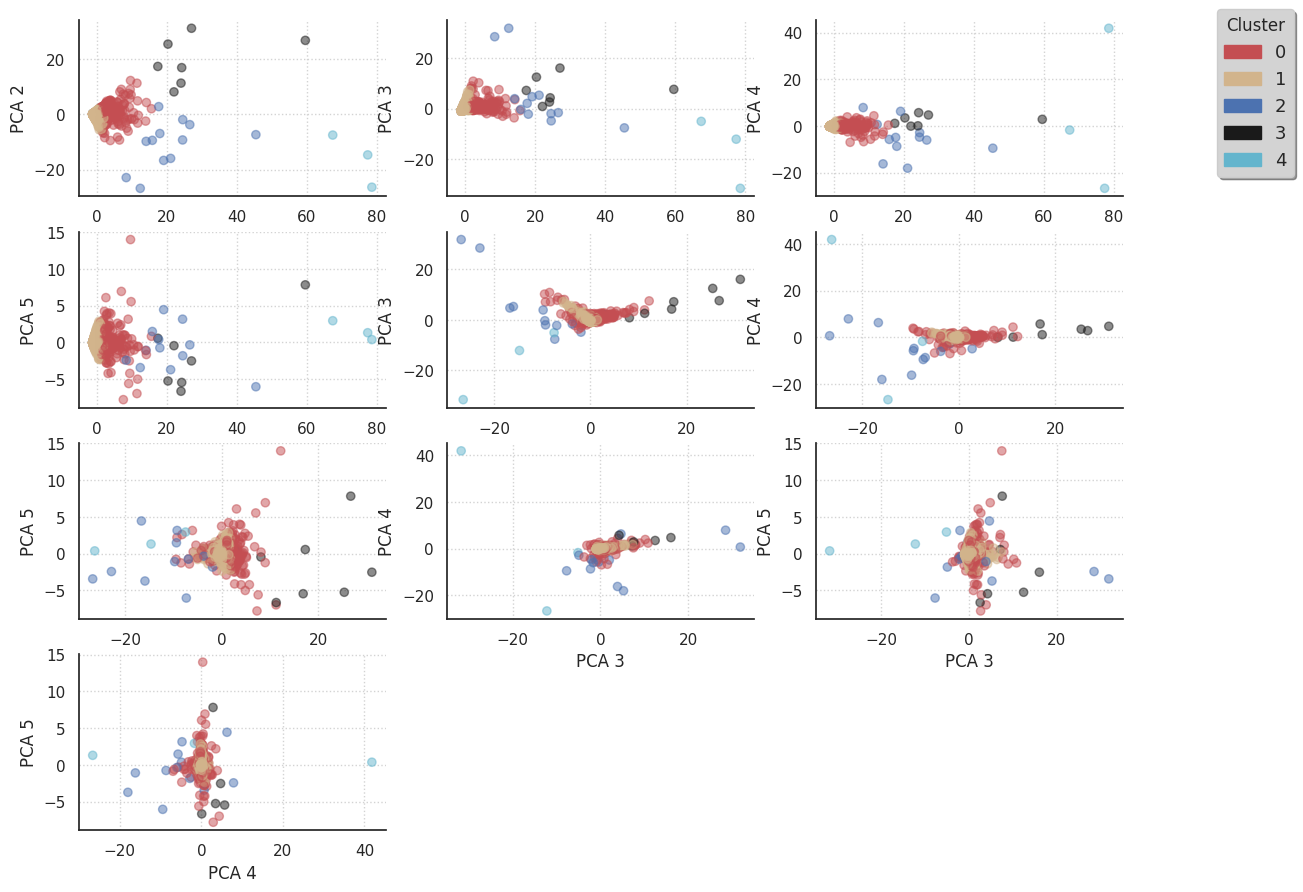

In [ ]:
import matplotlib.patches as mpatches

sns.set_style("white")
sns.set_context("notebook", font_scale=1, rc={"lines.linewidth": 2.5})

LABEL_COLOR_MAP = {0:'r', 1:'tan', 2:'b', 3:'k', 4:'c'}
label_color = [LABEL_COLOR_MAP[l] for l in embeddings['clusters']]

fig = plt.figure(figsize = (12,10))
increment = 0
for ix in range(5):
    for iy in range(ix+1, 5):
        increment += 1
        ax = fig.add_subplot(4,3,increment)
        ax.scatter(embeddings[ix], embeddings[iy], c= label_color, alpha=0.5)
        plt.ylabel('PCA {}'.format(iy+1), fontsize = 12)
        plt.xlabel('PCA {}'.format(ix+1), fontsize = 12)
        ax.yaxis.grid(color='lightgray', linestyle=':')
        ax.xaxis.grid(color='lightgray', linestyle=':')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)

        if increment == 12: break
    if increment == 12: break

comp_handler = []
for i in range(n_clusters):
    comp_handler.append(mpatches.Patch(color = LABEL_COLOR_MAP[i], label = i))

plt.legend(handles=comp_handler, bbox_to_anchor=(1.1, 0.9),
           title='Cluster', facecolor = 'lightgrey',
           shadow = True, frameon = True, framealpha = 1,
           fontsize = 13, bbox_transform = plt.gcf().transFigure)

plt.tight_layout()

In [ ]:
mix_df = mix_df.reset_index()
mix_df['clusters'] = embeddings['clusters']
mix_df.set_index(['Customer ID'])


,count,min,max,mean,sum,product_group_0_price,product_group_1_price,product_group_2_price,product_group_3_price,product_group_4_price,total_price,Quantity,Fall,Spring,Summer,Winter,clusters
Customer ID,,,,,,,,,,,,,,,,,
12346,11,1.00,142.31,33.487273,368.36,0.00,0.00,0.00,202.25,166.11,368.36,69,0,5,19,9,1
12347,2,611.53,711.79,661.660000,1323.32,312.90,353.40,200.98,276.35,179.69,1323.32,828,40,0,0,31,1
12348,1,222.16,222.16,222.160000,222.16,0.00,69.60,151.56,0.00,1.00,222.16,373,20,0,0,0,1
12349,3,200.00,1402.62,890.380000,2671.14,249.00,587.40,204.00,166.65,1464.09,2671.14,993,55,47,0,0,1
12351,1,300.93,300.93,300.930000,300.93,82.80,102.48,73.20,29.70,12.75,300.93,261,21,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,6,32.20,163.15,103.228333,619.37,131.90,219.99,64.53,68.40,134.55,619.37,322,59,79,39,40,1
18284,1,461.68,461.68,461.680000,461.68,86.40,56.70,206.58,62.00,50.00,461.68,494,28,0,0,0,1
18285,1,427.00,427.00,427.000000,427.00,204.00,33.60,18.00,19.80,151.60,427.00,145,0,0,0,12,1


In [ ]:
columns = ['mean', 'product_group_0_price',	'product_group_1_price', 'product_group_2_price', 'product_group_3_price', 'product_group_4_price']
X, Y = mix_df[columns], mix_df['clusters']

X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

In [ ]:
!pip install tpot
from tpot import TPOTClassifier

In [ ]:
tpot = TPOTClassifier(verbosity=2, max_time_mins=2)
tpot.fit(X_train, Y_train)
print(tpot.score(X_test, Y_test))

Optimization Progress:   0%|          | 0/100 [00:00<?, ?pipeline/s]


2.00 minutes have elapsed. TPOT will close down.
TPOT closed during evaluation in one generation.


TPOT closed prematurely. Will use the current best pipeline.

Best pipeline: GradientBoostingClassifier(CombineDFs(input_matrix, input_matrix), learning_rate=0.01, max_depth=8, max_features=0.3, min_samples_leaf=8, min_samples_split=14, n_estimators=100, subsample=0.7500000000000001)
0.965034965034965


In [ ]:
X_test

,mean,product_group_0_price,product_group_1_price,product_group_2_price,product_group_3_price,product_group_4_price
370,747.100000,87.60,386.50,23.50,270.90,2967.00
2976,243.750000,159.30,283.08,139.52,105.40,43.95
3822,99.300000,61.20,0.00,10.20,37.50,89.70
1488,200.872500,547.95,348.55,241.09,312.55,156.84
2151,357.314000,346.00,582.72,565.02,209.85,82.98
...,...,...,...,...,...,...
3174,220.970000,53.20,101.85,56.02,9.90,0.00
593,217.621429,809.80,347.21,250.64,40.35,75.35
3028,87.800000,0.00,52.10,0.00,0.00,35.70
245,1185.020000,232.80,454.08,337.34,160.80,0.00
